## Vision transformers

Outline:
- Fill in model architecture (maybe ask them to implement attention by hand? might be too hard)
- Load pretrained weights
- Load ImageNet
- Fine-tune on ImageNet (write training loop)

## Vision transformer architecture

First, go to `vit_architecture.py` and fill in some model definitions. You might find this illustration of the architecture of a vision transformer helpful (Figure 1 from the [ViT paper](https://arxiv.org/pdf/2010.11929.pdf)).

![](vit_architecture.png)

Once you complete all the TODOs, run the cell below to import the model.

In [4]:
%load_ext autoreload
%autoreload 2

from vit_architecture_solutions import VisionTransformer
# from vit_architecture import VisionTransformer

config = {
    "num_classes": 10,
    "patch_size": 16,
    "hidden_size": 384,
    "model_name": 'ViT-S_16',
}

transformer_config = {
    "mlp_dim": 1536,
    "num_heads": 6,
    "num_layers": 12,
    "attention_dropout_rate": 0.0,
    "dropout_rate": 0.0,
}

LOAD_PRETRAINED = False

model = VisionTransformer(
    num_classes=config["num_classes"], 
    patch_size=config["patch_size"],
    hidden_size=config["hidden_size"],
    model_name=config["model_name"],
    transformer_config=transformer_config,
)

model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


VisionTransformer(
    # attributes
    num_classes = 10
    patch_size = 16
    hidden_size = 384
    transformer_config = {'mlp_dim': 1536, 'num_heads': 6, 'num_layers': 12, 'attention_dropout_rate': 0.0, 'dropout_rate': 0.0}
    cls_head_bias_init = 0.0
    model_name = 'ViT-S_16'
)

## Load pre-trained weights

In [6]:
import os
import numpy as np
import jax
import jax.numpy as jnp
import flax
import optax
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import einops
# import tqdm
from tqdm import tqdm
from vit_utils import load_pretrained, get_cifar10, NumpyLoader, accumulate_gradient, one_hot
# jax.local_devices() # shows available devices

[autoreload of numpy.matrixlib failed: Traceback (most recent call last):
  File "/home/yuslzp/.conda/envs/jax/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 261, in check
    superreload(m, reload, self.old_objects)
  File "/home/yuslzp/.conda/envs/jax/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 459, in superreload
    module = reload(module)
  File "/home/yuslzp/.conda/envs/jax/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/home/yuslzp/.conda/envs/jax/lib/python3.10/site-packages/numpy/matrixlib/__init__.py", line 6, in <module>
    __all__ = defmatrix.__all__
NameError: name 'defmatrix' is not defined
]
[autoreload of numpy.lib failed: Traceback (most recent call last):
  F

AttributeError: Module 'numpy.core' has no attribute 'numerictypes'

In [ ]:
# Download pretrained S_16 checkpoint
checkpoint_file = "S_16-i21k-300ep-lr_0.001-aug_light1-wd_0.03-do_0.0-sd_0.0.npz"
if not os.path.exists("checkpoints"):
    os.system("mkdir checkpoints")
os.chdir("checkpoints")
if not os.path.exists(checkpoint_file):
    os.system(f"wget https://storage.googleapis.com/vit_models/augreg/{checkpoint_file}")
os.chdir("..")
with open(f"checkpoints/{checkpoint_file}", "rb") as f:
    ckpt_dict = np.load(f, allow_pickle=False)
    keys, values = zip(*list(ckpt_dict.items()))

# Initialize the model with random parameters
variables = jax.jit(lambda: model.init(
    jax.random.PRNGKey(0),
    np.random.randn(2, 224, 224, 3),
    train=False,
), backend='cpu')()

In [ ]:
if LOAD_PRETRAINED:
    # Load checkpoint
    params = load_pretrained(
        pretrained_path=f'checkpoints/{checkpoint_file}',
        init_params=variables['params'],
    )
else:
    params = variables['params']

## Load CIFAR-10

TODO: Also load ImageNet and check that performance is good on it out of the box.

In this section, we will fine-tune our vision transformer on CIFAR-10. CIFAR-10 is an image dataset with 10 classes. If you are not familiar with the dataset, you can read about it [here](https://www.cs.toronto.edu/~kriz/cifar.html). Since our model was trained on ImageNet, a much bigger and more complex dataset, CIFAR-10 should be relatively easy.

First, let's load the dataset and check the model's performance before any fine-tuning.

Files already downloaded and verified
Files already downloaded and verified
Label: truck


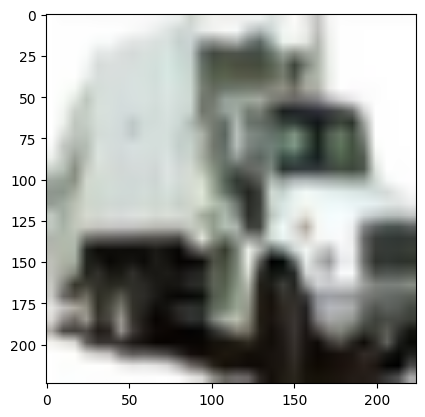

In [5]:
n_targets = 10
batch_size = 128
cifar10_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Get datasets from torchvision
cifar10_train, cifar10_test = get_cifar10()
train_loader = DataLoader(cifar10_train, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(cifar10_test, batch_size=batch_size, pin_memory=True)

# Show an example image
for images, labels in train_loader:
    plt.imshow(einops.rearrange(images[0], "c h w -> h w c"))
    print(f"Label: {cifar10_labels[labels[0]]}")
    break

In [6]:
# This cell contains some JAX setup that you do not have to understand.

# So far, all our data is in the host memory. Let's now replicate the arrays
# into the devices.
# This will make every array in the pytree params become a ShardedDeviceArray
# that has the same data replicated across all local devices.
# For TPU it replicates the params in every core.
# For a single GPU this simply moves the data onto the device.
# For CPU it simply creates a copy.
params_repl = flax.jax_utils.replicate(params)
print('params.cls:', type(params['head']['bias']).__name__,
      params['head']['bias'].shape)
print('params_repl.cls:', type(params_repl['head']['bias']).__name__,
      params_repl['head']['bias'].shape)

# Then map the call to our model's forward pass onto all available devices.
vit_apply_repl = jax.pmap(lambda params, inputs: model.apply(
    dict(params=params), inputs, train=False))

params.cls: DeviceArray (10,)
params_repl.cls: ShardedDeviceArray (1, 10)


In [7]:
# Check the accuracy on CIFAR-10 without fine-tuning

def get_accuracy(params_repl, torch_loader: DataLoader):
  """Returns accuracy evaluated on the test set."""
  good = total = 0
  for image, label in tqdm(torch_loader):
      image = image.unsqueeze(0).numpy()
      image = einops.rearrange(image, "n b c h w -> n b h w c")
      # ---------- student TODO -----------
      predicted = vit_apply_repl(params_repl, image).squeeze()
      is_same = predicted.argmax(axis=-1) == label.numpy()
      good += is_same.sum()
      total += len(is_same.flatten())
      # -----------------------------------
  return good / total

get_accuracy(params_repl, test_loader)

100%|██████████| 79/79 [00:21<00:00,  3.65it/s]


DeviceArray(0.1, dtype=float32)

Question x: How is the model's performance on CIFAR-10 without any fine-tuning? Is this surprising?

## Fine-tune

[Explain what is fine-tuning]

In [8]:
# Training parameters
total_steps = 100
warmup_steps = 5
grad_norm_clip = 1
# This controls in how many forward passes the batch is split. 8 works well with
# a TPU runtime that has 8 devices. 64 should work on a GPU. You can of course
# also adjust the batch_size above, but that would require you to adjust the
# learning rate accordingly.
accum_steps = 8
base_lr = 0.03
update_rng_repl = flax.jax_utils.replicate(jax.random.PRNGKey(0))

Notice how at the beginning of the semester we discussed how to change learning rates. In practice, peeople use something called ``scheduler`` that controls the learning rate.
We will use a cosine learning rate schedule. Fill in the function below.

You can refer to https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html for the equation.

In [9]:
def create_cosine_lr_schedule(total_steps, base, warmup_steps,):
  """Creates a cosine learning rate schedule.
  Args:
    total_steps: The total number of steps to run.
    base: The starting learning-rate (without warmup).
    warmup_steps: how many steps to warm up for.
  Returns:
    A function learning_rate(step): float -> {"learning_rate": float}.
  """

  def step_fn(step):
    """Step to learning rate function."""
    lr = base
    progress = (step - warmup_steps) / float(total_steps - warmup_steps)
    progress = jnp.clip(progress, 0.0, 1.0)
    lr = lr * 0.5 * (1. + jnp.cos(jnp.pi * progress))
    if warmup_steps:
      lr = lr * jnp.minimum(1., step / warmup_steps)

    return jnp.asarray(lr, dtype=jnp.float32)

  return step_fn

[Maybe have students fill in cross entropy loss?]

In [10]:
def make_update_fn(*, apply_fn, accum_steps, tx):
  """Returns update step for data parallel training."""

  def update_fn(params, opt_state, batch, rng):

    _, new_rng = jax.random.split(rng)
    # Bind the rng key to the device id (which is unique across hosts)
    # Note: This is only used for multi-host training (i.e. multiple computers
    # each with multiple accelerators).
    dropout_rng = jax.random.fold_in(rng, jax.lax.axis_index('batch'))

    def cross_entropy_loss(*, logits, labels):
      logp = jax.nn.log_softmax(logits)
      #print(f"{logp.shape=}, {labels.shape=}")
      return -jnp.mean(jnp.sum(logp * labels, axis=1))

    def loss_fn(params, images, labels):
      logits = apply_fn(
          dict(params=params),
          rngs=dict(dropout=dropout_rng),
          inputs=images,
          train=True)
      return cross_entropy_loss(logits=logits, labels=labels)

    l, g = accumulate_gradient(
        jax.value_and_grad(loss_fn), params, batch[0], batch[1],
        accum_steps)
    g = jax.tree_map(lambda x: jax.lax.pmean(x, axis_name='batch'), g)
    updates, opt_state = tx.update(g, opt_state)
    params = optax.apply_updates(params, updates)
    l = jax.lax.pmean(l, axis_name='batch')

    return params, opt_state, l, new_rng

  return jax.pmap(update_fn, axis_name='batch', donate_argnums=(0,))

In [11]:
lr_fn = create_cosine_lr_schedule(total_steps, base_lr, warmup_steps)
# We use a momentum optimizer that uses half precision for state to save
# memory. It als implements the gradient clipping.
tx = optax.chain(
    optax.clip_by_global_norm(grad_norm_clip),
    optax.sgd(
        learning_rate=lr_fn,
        momentum=0.9,
        accumulator_dtype='bfloat16',
    ),
)
update_fn_repl = make_update_fn(
    apply_fn=model.apply, accum_steps=accum_steps, tx=tx)
opt_state = tx.init(params)
opt_state_repl = flax.jax_utils.replicate(opt_state)

In [12]:
losses = []
lrs = []
# Completes in ~20 min on the TPU runtime.
# NOTE: I'm confused as this took < 1 min on my GPU (RTX A6000). Maybe my GPU is 20 times faster than a TPU from a few years ago?!
# TODO: Someone else should test how fast this is on their machine/on Colab.

train_np_loader = NumpyLoader(cifar10_train, batch_size=batch_size, num_workers=0)

for step, batch in tqdm(zip(
    np.arange(1, total_steps + 1),
    train_np_loader,
)):
  # reshape images and labels appropriately
  images = batch[0].reshape(1, batch_size, 224, 224, 3)
  labels = one_hot(batch[1].squeeze(), 10).reshape(1,batch_size,-1)
  params_repl, opt_state_repl, loss_repl, update_rng_repl = update_fn_repl(
      params_repl, opt_state_repl, (images, labels), update_rng_repl)
  losses.append(loss_repl[0])
  lrs.append(lr_fn(step))

100it [00:51,  1.94it/s]


Let's plot the loss curve and learning rate schedule to see if training functioned as expected.

Text(0.5, 0, 'steps')

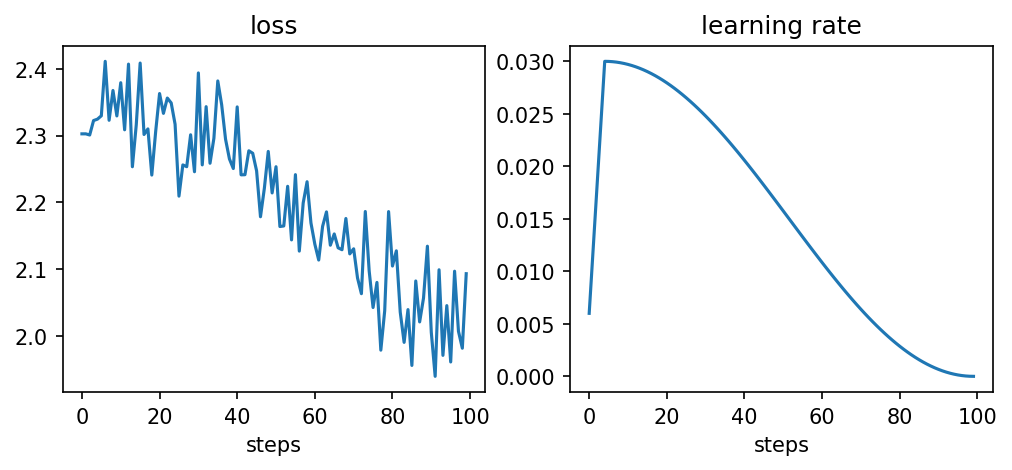

In [13]:
fig = plt.figure(dpi=150, figsize=(8, 3))
plt.subplot(121)
plt.plot(losses)
plt.title("loss")
plt.xlabel("steps")
plt.subplot(122)
plt.plot(lrs)
plt.title("learning rate")
plt.xlabel("steps")

Now we can test the model's accuracy on CIFAR-10 again using the `get_accuracy()` function you wrote.

In [14]:
get_accuracy(params_repl, test_loader)

100%|██████████| 79/79 [00:13<00:00,  5.76it/s]


DeviceArray(0.1763, dtype=float32)

Change the `LOAD_PRETRAINED` flag at the top of the file and run the notebook again. Now we are not loading in pretrained weights, and the model's weights are randomly initialized. Train this model for one epoch (the same number of steps as the fine-tuning portion). What is the accuracy after training the model for the same amount of time?

[For comparison, the pretrained ViT achieves 92% accuracy and the randomly initialized model achieves 17% for the staff solution.]

## Citation

In [ ]:
##### IGNORE BELOW #####

def cross_entropy_loss(logits, labels):
  logp = jax.nn.log_softmax(logits)
  #print(f"{logp.shape=}, {labels.shape=}")
  return -jnp.mean(jnp.sum(logp * labels, axis=1))

def loss_fn(model, params, images, labels):
  logits = model.apply(
      dict(params=params),
      #rngs=dict(dropout=dropout_rng),
      inputs=images,
      train=True)
  return cross_entropy_loss(logits=logits, labels=labels)

# Define the learning rate schedule
lr_fn = create_cosine_lr_schedule(total_steps, base_lr, warmup_steps)
# We use a momentum optimizer that uses half precision for state to save
# memory. It als implements the gradient clipping.
tx = optax.chain(
    optax.clip_by_global_norm(grad_norm_clip),
    optax.sgd(
        learning_rate=lr_fn,
        momentum=0.9,
        accumulator_dtype='bfloat16',
    ),
)

opt_state = tx.init(params)
opt_state_repl = flax.jax_utils.replicate(opt_state)

# Write the training loop
train_np_loader = NumpyLoader(cifar10_train, batch_size=batch_size, num_workers=0)

for step, batch in tqdm(zip(
    np.arange(1, total_steps + 1),
    train_np_loader,
)):
  # reshape batch
  images = batch[0].reshape(1, batch_size, 224, 224, 3)
  labels = one_hot(batch[1].squeeze(), 10).reshape(1,batch_size,-1)
  # Compute the loss and gradient
  loss, grads = jax.value_and_grad(loss_fn)(model, params_repl, images, labels)

  # Update the weights of the model using the optimizer
  updates, opt_state_repl = tx.update(grads, opt_state_repl)
  params_repl = optax.apply_updates(params_repl, updates)
  loss = jax.lax.pmean(loss, axis_name='batch')

  if step % 10 == 0:
    print(f"Step: {step}, Loss: {loss}")